# Predicting ICU Transfer: MIMIC-IV
## Machine Learning Models

*name*: Margaret Pozo  
*date*: Sept. 8, 2025

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve

In [2]:
# imputed dataset
df = pd.read_csv("icu_01_bertsimas.csv", parse_dates=["calendar_day", "admittime", "intime", "outtime"])

# dropping non-feature columns
drop_cols = [
    "subject_id", "hadm_id", "stay_id",
    "calendar_day", "admittime", "intime", "outtime",
    "icu_day_start", "icu_day_end",
    "label_icu", "label_exit"
]

# split labels and features
y = df["label_icu"]
X = df.drop(columns=drop_cols)

# encoding categorical columns 
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
print("Encoding these categorical features:", list(categorical_cols))

# one-hot encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


Encoding these categorical features: ['gender', 'insurance', 'language', 'marital_status', 'admission_location', 'discharge_location', 'admission_type']


### Random Forest Model

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0      0.960     0.985     0.972     11601
           1      0.055     0.021     0.030       487

    accuracy                          0.946     12088
   macro avg      0.507     0.503     0.501     12088
weighted avg      0.923     0.946     0.934     12088

AUC Score: 0.5448558477664338


### Calibration Curve

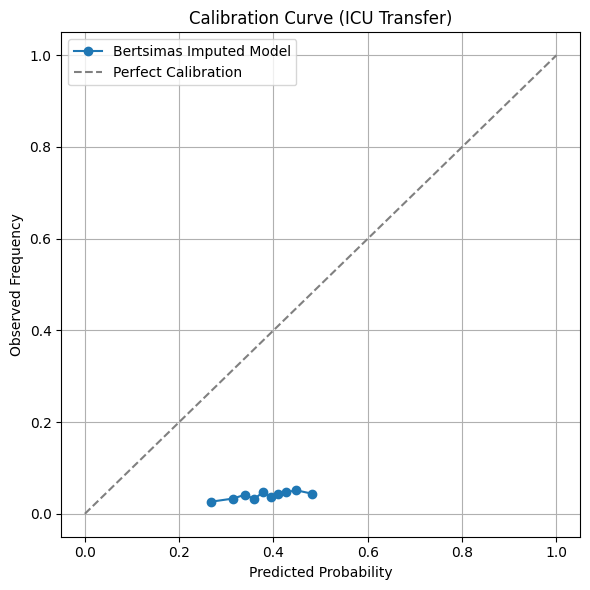

In [4]:
# bin probabilities into quantiles
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='quantile')

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Bertsimas Imputed Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve (ICU Transfer)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Decision Curve Analysis

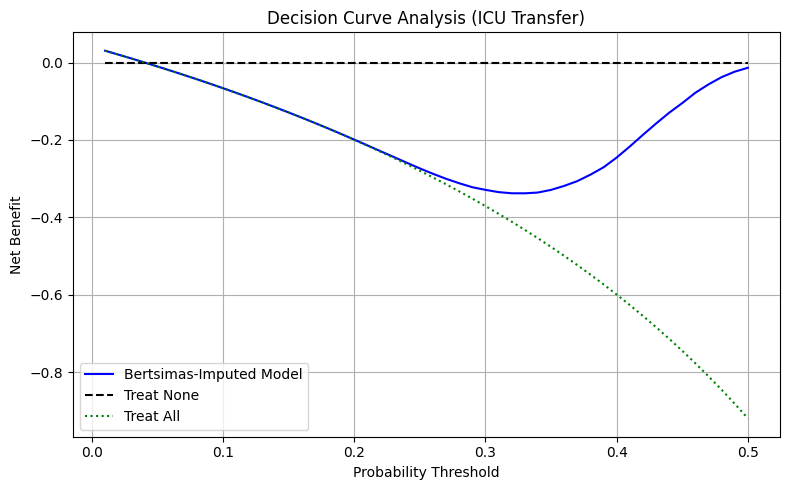

In [5]:
def decision_curve(y_true, y_prob, thresholds):
    n = len(y_true)
    results = []
    for threshold in thresholds:
        preds = y_prob >= threshold
        tp = ((y_true == 1) & (preds)).sum()
        fp = ((y_true == 0) & (preds)).sum()
        net_benefit = tp/n - fp/n * (threshold / (1 - threshold))
        results.append({"Threshold": threshold, "Net Benefit": net_benefit})
    return pd.DataFrame(results)

# thresholds from 1% to 50%
thresholds = np.linspace(0.01, 0.5, 50)
dca_df = decision_curve(y_test.values, y_prob, thresholds)

plt.figure(figsize=(8,5))
plt.plot(dca_df["Threshold"], dca_df["Net Benefit"], label="Bertsimas-Imputed Model", color='blue')
plt.plot(dca_df["Threshold"], [0]*len(dca_df), linestyle='--', color='black', label="Treat None")
plt.plot(
    dca_df["Threshold"],
    [y_test.mean() - (t/(1-t))*(1 - y_test.mean()) for t in dca_df["Threshold"]],
    linestyle=':', color='green', label="Treat All"
)
plt.xlabel("Probability Threshold")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (ICU Transfer)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Feature Importance

/tmp/ipykernel_2010/414229446.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_feats.values, y=top_feats.index, palette="viridis")


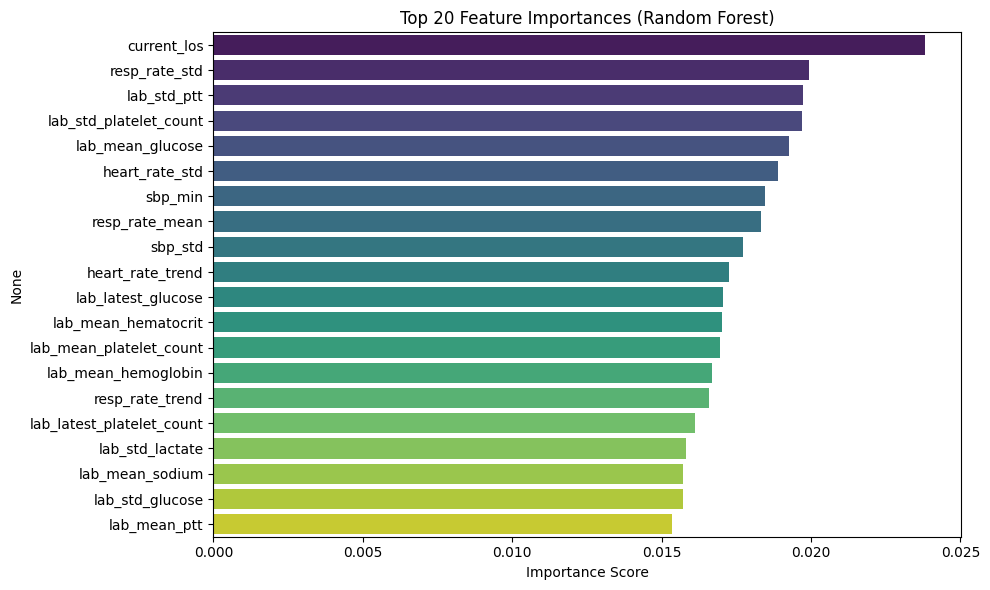

In [6]:
importances = pd.Series(model.feature_importances_, index=X.columns)

# top N features
top_n = 20
top_feats = importances.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_feats.values, y=top_feats.index, palette="viridis")
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [17]:
# anchors
icu = df.copy()
icu["day_start"] = pd.to_datetime(icu["calendar_day"]).dt.floor("D")
icu["t_k"]       = icu["day_start"] + pd.Timedelta(days=1)      # end of ICU day
icu["t_k_plus"]  = icu["t_k"] + pd.Timedelta(days=1)            # 24h look-ahead

# must be in this ICU stay at the anchor time
risk = (icu["t_k"] >= icu["intime"]) & (icu["t_k"] < icu["outtime"])
print("Risk-set keep ratio:", float(risk.mean()))
icu = icu[risk].copy()

# label_exit from ICU stay outtime
icu["label_exit"] = ((icu["outtime"] > icu["t_k"]) & (icu["outtime"] <= icu["t_k_plus"])).astype(int)

# prepare transfers per hadm_id
transfers = pd.read_csv(
    "shared/mimic4/physionet.org/hosp/transfers.csv",
    usecols=["hadm_id","careunit","intime","outtime"],
    parse_dates=["intime","outtime"]
).dropna(subset=["hadm_id"])

transfers["hadm_id"] = transfers["hadm_id"].astype("int64")
icu["hadm_id"]       = icu["hadm_id"].astype("int64")

# ICU unit detector
icu_units = ["ICU","MICU","SICU","CCU","TSICU","NSICU","NICU","CSRU"]
transfers["careunit_u"] = transfers["careunit"].fillna("").str.upper()
transfers["is_icu"]     = transfers["careunit_u"].str.contains("|".join(icu_units))

# only keep hadm_ids we need and sort
transfers = transfers[transfers["hadm_id"].isin(icu["hadm_id"].unique())].copy()
transfers = transfers.sort_values(["hadm_id","intime"]).reset_index(drop=True)

# numpy arrays for intime/outtime/is_icu/unit
tr_by_hadm = {}
for hadm, g in transfers.groupby("hadm_id", sort=False):
    tr_by_hadm[int(hadm)] = (
        g["intime"].to_numpy(),
        g["outtime"].to_numpy(),
        g["is_icu"].to_numpy(),
        g["careunit_u"].to_numpy()
    )

# compute label_icu with a simple search
def label_icu_for_row(hadm_id, t_k):
    """
    Returns 0/1 for ICU->ICU within (t_k, t_k+24h],
    requiring patient in ICU at t_k and the next move within 24h goes to ICU.
    """
    tup = tr_by_hadm.get(int(hadm_id))
    if tup is None:
        return 0  # no transfer data for this admission

    intime_arr, out_arr, isicu_arr, unit_arr = tup

    # find row 'idx' such that intime[idx] <= t_k < outtime[idx] (current location)
    idx = np.searchsorted(intime_arr, t_k, side="right") - 1
    if idx < 0:
        return 0
    # if outtime is NaT, treat as ongoing; else require t_k < outtime[idx]
    if not (pd.isna(out_arr[idx]) or (t_k < out_arr[idx])):
        return 0

    current_is_icu = bool(isicu_arr[idx])
    if not current_is_icu:
        return 0  # patient not in ICU at t_k by transfers table 

    current_unit = unit_arr[idx]

    next_idx = np.searchsorted(intime_arr, t_k, side="right")
    if next_idx >= len(intime_arr):
        return 0

    next_intime = intime_arr[next_idx]
    # within 24h
    if not (next_intime > t_k and next_intime <= t_k + np.timedelta64(1, 'D')):
        return 0

    next_is_icu  = bool(isicu_arr[next_idx])
    next_unit    = unit_arr[next_idx]

    # label ICU->ICU if next destination is ICU / a different ICU unit
    return int(next_is_icu and (next_unit != current_unit))

# vectorized loop 
icu["label_icu"] = [
    label_icu_for_row(hadm, t)
    for hadm, t in zip(icu["hadm_id"].to_numpy(), icu["t_k"].to_numpy())
]

print("Prevalence — label_icu:", round(float(icu["label_icu"].mean()), 4))
print("Prevalence — label_exit:", round(float(icu["label_exit"].mean()), 4))

# merge fixed labels back to your frame
labels_small = icu[["stay_id","day_start","label_icu","label_exit"]].copy()
icu_df = df.merge(labels_small, on=["stay_id","day_start"], how="left")


Risk-set keep ratio: 0.9985771012574454
Prevalence — label_icu: 0.0214
Prevalence — label_exit: 0.1186


KeyError: 'day_start'

In [6]:
df = pd.read_csv("icu_discharge_labels.csv", parse_dates=["calendar_day","admittime","intime","outtime"])
drop_cols = [
    "subject_id","hadm_id","stay_id",
    "calendar_day","admittime","intime","outtime",
    "icu_day_start","icu_day_end","day_start",
    "label_icu","label_exit"
]

X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["label_icu"]
categorical_cols = X.select_dtypes(include=["object","category"]).columns
if len(categorical_cols) > 0:
    print("Encoding categoricals:", list(categorical_cols))
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


Encoding categoricals: ['gender', 'insurance', 'language', 'marital_status', 'admission_location', 'discharge_location', 'admission_type']


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Classification Report (ICU Transfer):")
print(classification_report(y_test, y_pred, digits=3))

print("AUC:", roc_auc_score(y_test, y_prob))


Classification Report (ICU Transfer):
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000     11813
         1.0      1.000     1.000     1.000       258

    accuracy                          1.000     12071
   macro avg      1.000     1.000     1.000     12071
weighted avg      1.000     1.000     1.000     12071

AUC: 1.0


In [8]:
train_ids = set(X_train.index)
test_ids = set(X_test.index)
overlap = len(train_ids & test_ids)
print("Overlap between train and test:", overlap)

Overlap between train and test: 0


In [9]:
for col in X.columns:
    corr = np.corrcoef(X[col], y)[0,1]
    if abs(corr) > 0.9:
        print(col, corr)


label_icu_y 0.9999999999999998


In [10]:
[col for col in X.columns if "label" in col.lower()]


['label_icu_x', 'label_exit_x', 'label_icu_y', 'label_exit_y']

In [11]:
drop_cols = [
    "subject_id","hadm_id","stay_id",
    "calendar_day","admittime","intime","outtime",
    "icu_day_start","icu_day_end","day_start",
    "label_icu","label_exit","label_icu_x","label_icu_y"
]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])


In [12]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=df["stay_id"]))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [13]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=df["stay_id"]))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [15]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer  # only as a guard; won’t run if no NaNs
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

df = pd.read_csv("icu_discharge_labels.csv")

target_col = "label_icu" if "label_icu" in df.columns else "label_exit"
y = df[target_col].astype(int)

label_cols = [c for c in df.columns if "label" in c.lower()]
non_feature_cols = [
    "subject_id","hadm_id","stay_id",
    "calendar_day","admittime","intime","outtime",
    "icu_day_start","icu_day_end","day_start"
]
drop_cols = list(set(label_cols + non_feature_cols))
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Feature types
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

assert not any("label" in c.lower() for c in X.columns), "Label column leaked into X."
has_nans = X.isnull().sum().sum() > 0

# model
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
pipe = Pipeline(steps=[("prep", preprocessor), ("model", clf)])

# split 
group_key = None
for g in ["stay_id","hadm_id","subject_id"]:
    if g in df.columns:
        group_key = g
        break
if group_key is None:
    raise ValueError("Need a grouping column (stay_id/hadm_id/subject_id) to avoid identity leakage.")

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df[group_key]))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print(f"Outcome: {target_col}")
print("Classification Report (group split):")
print(classification_report(y_test, y_pred, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("PR AUC (Average Precision):", average_precision_score(y_test, y_prob))


Outcome: label_icu
Classification Report (group split):
              precision    recall  f1-score   support

           0      0.979     1.000     0.989     11560
           1      0.200     0.004     0.008       243

    accuracy                          0.979     11803
   macro avg      0.590     0.502     0.499     11803
weighted avg      0.963     0.979     0.969     11803

ROC AUC: 0.6667460520882281
PR AUC (Average Precision): 0.047628091323190146


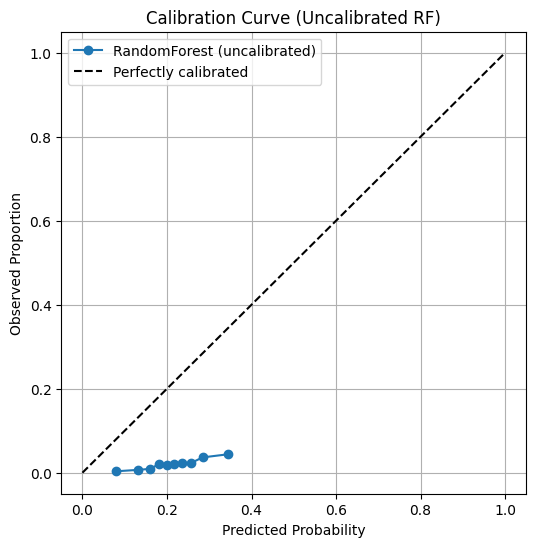

In [16]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Calibration curve before scaling
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, "o-", label="RandomForest (uncalibrated)")
plt.plot([0,1], [0,1], "k--", label="Perfectly calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Proportion")
plt.title("Calibration Curve (Uncalibrated RF)")
plt.legend()
plt.grid()
plt.show()


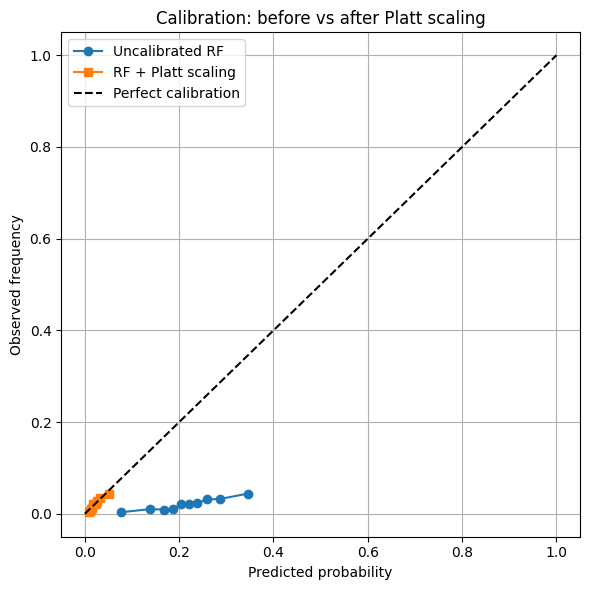

Uncalibrated ROC AUC: 0.6709431557663006
Calibrated   ROC AUC: 0.6710859071297365
Uncalibrated PR  AUC: 0.04674542434789136
Calibrated   PR  AUC: 0.04861388444748969

Classification report @0.5 (uncalibrated):
              precision    recall  f1-score   support

           0      0.979     1.000     0.990     11560
           1      0.500     0.004     0.008       243

    accuracy                          0.979     11803
   macro avg      0.740     0.502     0.499     11803
weighted avg      0.970     0.979     0.969     11803


Classification report @0.5 (calibrated):
              precision    recall  f1-score   support

           0      0.979     1.000     0.990     11560
           1      0.000     0.000     0.000       243

    accuracy                          0.979     11803
   macro avg      0.490     0.500     0.495     11803
weighted avg      0.959     0.979     0.969     11803



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

df = pd.read_csv("icu_discharge_labels.csv")

# Target
target_col = "label_icu"  # or "label_exit"
y = df[target_col].astype(int)

label_cols = [c for c in df.columns if "label" in c.lower()]
non_feats = ["subject_id","hadm_id","stay_id","calendar_day","admittime","intime","outtime","icu_day_start","icu_day_end","day_start"]
X = df.drop(columns=[c for c in set(label_cols + non_feats) if c in df.columns])

cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

# one-hot encode categoricals
preproc = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder="passthrough"
)

rf = RandomForestClassifier(
    n_estimators=300, max_depth=12, class_weight="balanced",
    random_state=42, n_jobs=-1
)

pipe = Pipeline([("prep", preproc), ("model", rf)])

group_key = "stay_id" if "stay_id" in df.columns else ("hadm_id" if "hadm_id" in df.columns else "subject_id")
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df[group_key]))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = df[group_key].iloc[train_idx]

pipe.fit(X_train, y_train)
y_prob_uncal = pipe.predict_proba(X_test)[:, 1]

gkf = GroupKFold(n_splits=5)
cal = CalibratedClassifierCV(
    estimator=pipe, method="sigmoid",
    cv=gkf.split(X_train, y_train, groups_train)  # group-aware CV on training data
)
cal.fit(X_train, y_train)
y_prob_cal = cal.predict_proba(X_test)[:, 1]

pt_unc, pp_unc = calibration_curve(y_test, y_prob_uncal, n_bins=10, strategy="quantile")
pt_cal, pp_cal = calibration_curve(y_test, y_prob_cal,  n_bins=10, strategy="quantile")

plt.figure(figsize=(6,6))
plt.plot(pp_unc, pt_unc, "o-", label="Uncalibrated RF")
plt.plot(pp_cal, pt_cal, "s-", label="RF + Platt scaling")
plt.plot([0,1], [0,1], "k--", label="Perfect calibration")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Calibration: before vs after Platt scaling")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

print("Uncalibrated ROC AUC:", roc_auc_score(y_test, y_prob_uncal))
print("Calibrated   ROC AUC:", roc_auc_score(y_test, y_prob_cal))
print("Uncalibrated PR  AUC:", average_precision_score(y_test, y_prob_uncal))
print("Calibrated   PR  AUC:", average_precision_score(y_test, y_prob_cal))

from sklearn.metrics import classification_report
print("\nClassification report @0.5 (uncalibrated):")
print(classification_report(y_test, (y_prob_uncal>=0.5).astype(int), digits=3))
print("\nClassification report @0.5 (calibrated):")
print(classification_report(y_test, (y_prob_cal>=0.5).astype(int), digits=3))
